In [31]:
import pandas as pd, numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from pandas import DataFrame

In [88]:
data = pd.read_csv("output/TECHM.csv")

In [89]:
def get_score(df: DataFrame, indicator: str, entry_type='long'):
	indicator = indicator.upper()
 
	if indicator == 'RSI' and entry_type == 'long':
		try:
			rsiValue = df.rsi.head(1).values[0]
			if rsiValue in range(60,70):
				return 5
			elif rsiValue in range(70,80):
				return 4
			elif rsiValue >= 80:
				return 3
			elif rsiValue in range(50,60):
				return 2
			else:
				return 0
		except IndexError:
			return 0
	if indicator == 'MACD' and entry_type == 'long':
		macd = df.macd_crossover
		try:
			date = macd.iloc[list(np.where(df["macd_crossover"] == 1)[0])].index.values[0]
			date = pd.to_datetime(date)
			dates = df.index.values
			for i in range(0,len(dates)):
				if pd.to_datetime(dates[i]).date() == date:
					return 5 - i
			return 0
		except IndexError:
			return 0
	if indicator == 'EMA' and entry_type == 'long':
		try:
			date = df.ema_crossover.iloc[list(np.where(df["ema_crossover"] == 1)[0])].index.values[0]
			date = pd.to_datetime(date)
			dates = df.index.values
			for i in range(0,len(dates)):
				if pd.to_datetime(dates[i]).date() == date:
					return 5 - i
			return 0
		except IndexError:
			return 0
	if indicator == 'VOLUME' and entry_type == 'long':
		try:
			date = df.volume_buy.iloc[list(np.where(df["volume_buy"] == 1)[0])].index.values[0]
			date = pd.to_datetime(date)
			dates = df.index.values
			for i in range(0,len(dates)):
				if pd.to_datetime(dates[i]).date() == date:
					return 5 - i
			return 0
		except IndexError:
			return 0
	return None
totalScoreL = [0,0,0,0,0]
for i in range(len(data.index.values)-5):
	df = data[i:i+5]
	rsiScore = get_score(df, indicator='rsi')
	macdScore = get_score(df, indicator='macd')
	emaScore = get_score(df, indicator='ema')
	volumeScore = get_score(df, indicator='volume')
	totalScore = rsiScore + macdScore + emaScore + volumeScore
	totalScoreL.append(totalScore)
len(totalScoreL)
data['totalScore'] = totalScoreL
data['totalScoreEma'] = data.totalScore.ewm(span=5).mean()

In [90]:
span = 20
data.set_index("Date", inplace=True)
data['dates'] = data.index.values
data['dates'] = data['dates'].apply(lambda x: x.split('-')[2])
totalScoreX = data.iloc[:,-2:-1]
data = data.iloc[-span:,:]
datesY = data["dates"]
datesY = datesY.astype(int)
totalScoreX = totalScoreX.iloc[-span:,:]

In [91]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(np.array(datesY).reshape(-1, 1), totalScoreX)

LinearRegression()

C:\Users\HP\AppData\Local\Programs\Python\Python38-32\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


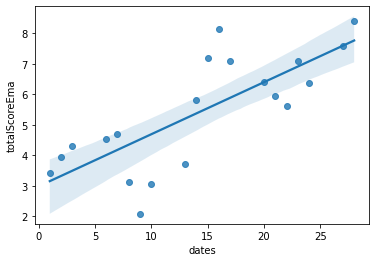

In [92]:
import seaborn as sns
sns.regplot(datesY, totalScoreX)
plt.show()

In [93]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(np.array(datesY).reshape(-1, 1), totalScoreX)

LinearRegression()

In [94]:
yhat = model.predict([[29]]) #predict score for next day
yhat

array([[7.93197503]])

In [95]:
data.iloc[:,-2:]

,totalScoreEma,dates
Date,,
2021-12-01,3.430956,01
2021-12-02,3.953971,02
2021-12-03,4.302647,03
2021-12-06,4.535098,06
2021-12-07,4.690066,07
2021-12-08,3.126710,08
2021-12-09,2.084473,09
2021-12-10,3.056316,10
2021-12-13,3.704210,13


In [96]:
from sklearn.ensemble import RandomForestRegressor

# create regressor object
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

# fit the regressor with x and y data
# x =Open	High	Low	Close	Volume
# y = 5EMA	26EMA	rsi	macd	macdSignal	macdHist
regressor.fit(np.asarray(data['totalScoreEma']).reshape(-1, 1),data['Close'])

RandomForestRegressor(random_state=0)

C:\Users\HP\AppData\Local\Programs\Python\Python38-32\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


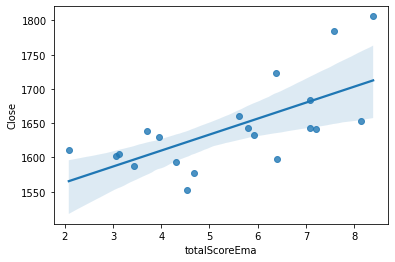

In [98]:
import seaborn as sns
sns.regplot(data['totalScoreEma'], data['Close'])
plt.show()

In [101]:
print(data.Close.std())
print(data.Close.values[-1])
regressor.predict(yhat)#predict close

64.89804844443148
1806.0999755859373


array([1678.30901733])